<a href="https://colab.research.google.com/github/theseregrets/dog-breed-predictor-flask/blob/main/dog_breed_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rishitashaw","key":"764db2446cb356314a26148352df0d10"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  
---------------------------------  ----------------------  -----  -------------------  -------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05            379  


In [6]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 99% 686M/691M [00:04<00:00, 166MB/s]
100% 691M/691M [00:04<00:00, 153MB/s]
/content


In [7]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/dogbreedidfromcomp.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: dog_dataset/train/840dbad5

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam


In [9]:
labels_all = pd.read_csv('dog_dataset/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
breeds_all = labels_all['breed']
breed_counts = breeds_all.value_counts()
breed_counts.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [11]:
CLASS_NAMES=['scottish_deerhound', 'maltese_dog', 'afghan_hound']
labels = labels_all[labels_all['breed'].isin(CLASS_NAMES)]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,146,0379145880ad3978f9b80f0dc2c03fba,afghan_hound


In [12]:
X_data = np.zeros((len(labels), 224, 224 ,3), dtype='float32')
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

for i in tqdm(range(len(labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size = (224, 224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(), axis = 0)
  X_data[i] = x/255.0

print('\nTrain Images shape: ', X_data.shape, ' size: {:,}'.format(X_data.size))
print('one-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 359/359 [00:01<00:00, 225.29it/s]


Train Images shape:  (359, 224, 224, 3)  size: 54,039,552
one-hot encoded output shape:  (359, 3)  size: 1,077


In [13]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

In [14]:
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)


In [15]:
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

Epoch 1/100
3/3 [==============================] - 18s 1s/step - loss: 4.9085 - accuracy: 0.3721 - val_loss: 4.8779 - val_accuracy: 0.3385
Epoch 2/100
3/3 [==============================] - 1s 272ms/step - loss: 4.8715 - accuracy: 0.3682 - val_loss: 4.8482 - val_accuracy: 0.3385
Epoch 3/100
3/3 [==============================] - 1s 269ms/step - loss: 4.8387 - accuracy: 0.3682 - val_loss: 4.8160 - val_accuracy: 0.3385
Epoch 4/100
3/3 [==============================] - 1s 271ms/step - loss: 4.8059 - accuracy: 0.3682 - val_loss: 4.7857 - val_accuracy: 0.3385
Epoch 5/100
3/3 [==============================] - 1s 272ms/step - loss: 4.7736 - accuracy: 0.3682 - val_loss: 4.7547 - val_accuracy: 0.3385
Epoch 6/100
3/3 [==============================] - 1s 271ms/step - loss: 4.7424 - accuracy: 0.3682 - val_loss: 4.7254 - val_accuracy: 0.3385
Epoch 7/100
3/3 [==============================] - 1s 272ms/step - loss: 4.7115 - accuracy: 0.3682 - val_loss: 4.6956 - val_accuracy: 0.3385
Epoch 8/100
3/3

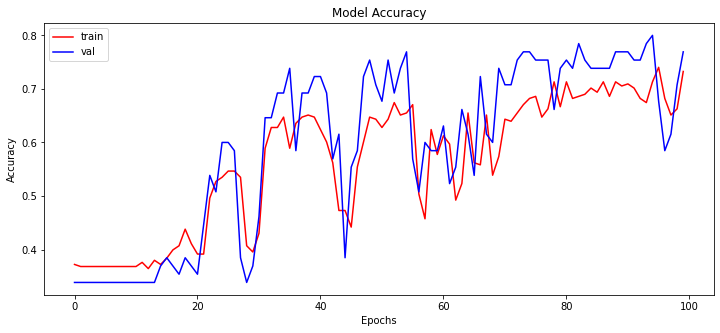

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [17]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 17ms/step - loss: 2.8286 - accuracy: 0.6667
Accuracy over the test set: 
  66.67 %


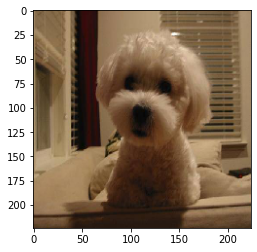

In [18]:
plt.imshow(X_test[1,:,:,:])
plt.show()

In [19]:
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

Originally :  maltese_dog
Predicted :  scottish_deerhound


In [20]:
model.save("dog_breed.h5")